# High-Resolution Net for Keypoint Detection

[High-Resolution Net (HRNet)](https://arxiv.org/abs/1902.09212) is a family of neural network architectures designed for handling vision tasks that require high-definition details from image. Some examples of such tasks are keypoint detection and small-object detection/segmentation.  

HRNet is an effort to address an important limitation of CNN designs: __as network goes deeper, the detailed spatial information tends to get lost.__ This is mainly due to the common CNN design philosophy of "increasing channel, decreasing spatial size". As a result, CNNs often have a difficult time on small-scale objects.

This is why many computer vision architecture uses multi-stage prediction to improve performance. For example, object detector nowadays (like YOLO, SOLO) rely on early stages of convolution features for smaller object detection and later convolution features for larger objects. Pyramid Network projects its high-level feature back to early stage to improve content richness. Unet concatenates features from encoder and decoder for all spatial dimensions. 

While networks mentioned above can indeed help with the limitation to a certain degree, they are all specific  solutions on the overall architecture level. In contrast, HRNet proposes a solution from a modular block level such that networks that leverage such block can inherit the benefits automatically. We will talk about details of HRNet design in later section.

For this particular example, we are showcasing HRnet with a keypoint detection task using MSCOCO dataset. MSCOCO contains 17 keypoints for different body keypoints of a person. To frame the keypoint detection task as a learning problem, one popular approach is to translate keypoint coordinates into pixel-level heat map and perform regression. In this example we will approach keypoint detection this way.

## Getting things ready

We will first import the modules required for training in this example:

In [1]:
import tempfile

import cv2
import numpy as np
import tensorflow as tf
from scipy.ndimage import center_of_mass
from tensorflow.keras import layers

import fastestimator as fe
from fastestimator.dataset import NumpyDataset
from fastestimator.dataset.data.mscoco import load_data
from fastestimator.op.numpyop.multivariate import LongestMaxSize, PadIfNeeded, Resize
from fastestimator.op.numpyop.numpyop import Delete, NumpyOp, RemoveIf
from fastestimator.op.numpyop.univariate import ReadImage
from fastestimator.op.tensorop.loss import MeanSquaredError
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.op.tensorop.normalize import Normalize
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.trace import Trace

Next, let's set up some hyperparameters related to the task:

In [2]:
data_dir=None
model_dir=tempfile.mkdtemp()
epochs=80
batch_size=128
train_steps_per_epoch=None
eval_steps_per_epoch=None
cache_limit=None

## Setting up Dataset

In MSCOCO dataset, not every image contains person's keypoint. In order to make the training efficient, we need to loop through the dataset quickly ahead of the training and filter out samples that are irrelevant to us. Furthermore, since HRNet is a single-object keypoint detector, we also need to isolate every object with keypoints when encountering multiple person within single image, and every person instance as a separate sample. 

In [3]:
def collect_single_keypoint_ds(ds, cache_limit=None):
    images, keypoints, keypoint_bboxes = [], [], []
    for idx in range(len(ds)):
        item = ds[idx]
        for keypoint, keypoint_bbox in zip(item['keypoint'], item['keypoint_bbox']):
            images.append(item['image'])
            keypoints.append(keypoint)
            keypoint_bboxes.append(keypoint_bbox)
        if idx % len(ds)//5 == 0:
            print("Loading data --- {} / {}".format((idx + 1)*len(ds)//5, len(ds)))
        if cache_limit and idx + 1 == cache_limit:
            break
    return NumpyDataset(data={"image": images, "keypoint": keypoints, "keypoint_bbox": keypoint_bboxes})

train_ds, eval_ds = load_data(root_dir=data_dir, load_bboxes=False, load_keypoints=True, replacement=False)
train_ds = collect_single_keypoint_ds(train_ds, cache_limit=cache_limit)
eval_ds = collect_single_keypoint_ds(eval_ds, cache_limit=cache_limit)

Loading data --- 23453 / 117266
Loading data --- 46906 / 117266
Loading data --- 70359 / 117266
Loading data --- 93812 / 117266
Loading data --- 117266 / 117266
Loading data --- 990 / 4952
Loading data --- 1980 / 4952
Loading data --- 2971 / 4952
Loading data --- 3961 / 4952
Loading data --- 4952 / 4952


Now we have loaded the data and created the samples, let's look at one sample of the dataset:

In [4]:
print("training dataset length is {}".format(len(train_ds)))
print("evaluation dataset length is {}".format(len(eval_ds)))

print("dataset sample:")
print(train_ds[0])

training dataset length is 149813
evaluation dataset length is 6352
dataset sample:
{'image': '/raid/shared_data/MSCOCO2017/train2017/000000000036.jpg', 'keypoint': array([[250, 244,   2],
       [265, 223,   2],
       [235, 235,   2],
       [309, 227,   2],
       [235, 253,   2],
       [355, 337,   2],
       [215, 342,   2],
       [407, 494,   2],
       [213, 520,   2],
       [445, 617,   2],
       [244, 447,   2],
       [338, 603,   2],
       [267, 608,   2],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=int32), 'keypoint_bbox': (167.58, 162.89, 310.61, 465.19)}


The `keypoint` is a 17x3 numpy array contains 17 keypoints for different body landmark, each represented in (x, y, v) format, with x and y being the coordinate of the keypoint, v being the visibility information defined as follows: `v=0`: keypoint not labeled. `v=1`: keypoint labeled but not visible. `v=2`: keypoint labeled and visible.  

The `keypoint_bbox` is the bounding box of the person, in (x1, y1, w, h) format.  we will use the bounding box information to crop the image for the training and validation.

## Creating Pipeline

Now that both training and validation datasets are created, we use `Pipeline` to define the online preprocessing operations required for every training step. Here are some note worthy details in the preprocessing task:

* As mentioned earlier, we are using the bounding box of the person to crop the body area, then resize the cropped image with longest size of 256 while preserving aspect ratio. To form a batch of multiple images, all images will be padded to 256 x 256 after the resizing.


* During the `LongestMaxSize` resizing, some keypoints on the border may get lost during interpolation. When this happens, we will remove the sample from the training or testing work flow.


* Due to memory constraints, the HRNet produce pixel-level mask downscaled by 4 times (same as official implementation). Therefore, we will generate the ground truth mask with size 64.  But we have also experimented the full resolution mask, and noticed around 16x longer time decrease without tangible improvement for this dataset. But it is possible that full resolution can be desirable for keypoint problems of smaller object.


* The ground truth mask is generated with a 2D gaussian centered around the keypoint coordinate and standard deviation of 1. This is only suitable for 64x64 mask, for higher mask dimension it is recommended to scale the standard deviation linearly or by the square root of the the scale factor.


* We are only considering the keypoints that are labeled (v=1 and v=2) during the training and validation.

In [5]:
class KeypointMask(NumpyOp):
    def forward(self, data, state):
        image, keypoint, kpscore = data
        height, width, _ = image.shape
        kp_mask = np.stack([self.gaussian(kp, ks, height, width) for kp, ks in zip(keypoint, kpscore)], axis=-1)
        return kp_mask

    def gaussian(self, kp, ks, height, width):
        x0, y0 = kp
        x0, y0 = int(x0), int(y0)
        mask = np.zeros((height, width), dtype="float32")
        if ks >= 1:
            y_min, y_max = max(y0 - 2, 0), min(y0 + 3, height)
            x_min, x_max = max(x0 - 2, 0), min(x0 + 3, width)
            for yi in range(y_min, y_max):
                for xi in range(x_min, x_max):
                    # only worry about the 5x5 around keypoint center
                    mask[yi, xi] = np.exp(-((xi - x0)**2 + (yi - y0)**2) / (2 * 1**2))
        return mask


class CropImageKeypoint(NumpyOp):
    def forward(self, data, state):
        image, keypoint_bbox, keypoint = data
        image = self._crop_image(image, keypoint_bbox)
        keypoints, kpscore = self._crop_keypoint(keypoint, keypoint_bbox)
        return image, keypoints, kpscore

    def _crop_image(self, image, bbox):
        x1, y1, box_w, box_h = bbox
        x2, y2 = x1 + box_w, y1 + box_h
        x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
        image = image[y1:y2, x1:x2]
        return image

    def _crop_keypoint(self, keypoints, bbox):
        x1, y1, w, h = bbox
        kpscore = keypoints[:, -1]
        x1, y1, w, h = int(x1), int(y1), int(w), int(h)
        kp_x = np.clip(keypoints[:, 0] - x1, a_min=0, a_max=w - 1)
        kp_y = np.clip(keypoints[:, 1] - y1, a_min=0, a_max=h - 1)
        keypoints = [(x, y) for x, y in zip(kp_x, kp_y)]
        return keypoints, kpscore



pipeline = fe.Pipeline(
    train_data=train_ds,
    eval_data=eval_ds,
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="image", outputs="image"),
        CropImageKeypoint(inputs=("image", "keypoint_bbox", "keypoint"), outputs=("image", "keypoint", "kpscore")),
        LongestMaxSize(max_size=256, image_in="image", keypoints_in="keypoint", keypoint_params='xy'),
        PadIfNeeded(min_height=256,
                    min_width=256,
                    image_in="image",
                    keypoints_in="keypoint",
                    keypoint_params='xy',
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0),
        Resize(height=64,
               width=64,
               image_in="image",
               image_out="image_down",
               keypoints_in="keypoint",
               keypoint_params='xy'),
        RemoveIf(fn=lambda x: len(x) < 17, replacement=False, inputs="keypoint"),
        KeypointMask(inputs=("image_down", "keypoint", "kpscore"), outputs="kp_mask"),
        Delete(keys=("keypoint", "keypoint_bbox", "kpscore"))
    ])

## Visualizing the preprocessed data

let's visualize a sample batch of preprocessed data that comes out of the pipeline during training:

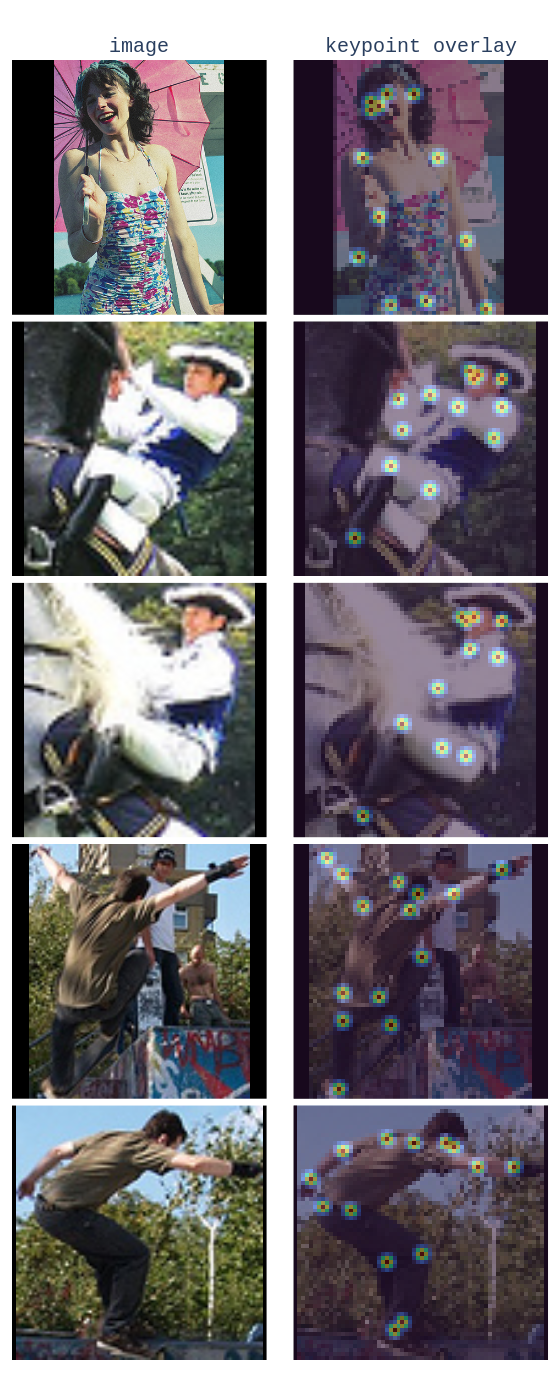

In [7]:
from fastestimator.util import BatchDisplay, GridDisplay

sample_batch = pipeline.get_results()
sample_masks = np.max(sample_batch["kp_mask"].numpy(), axis=-1) # reduce multi-channel mask into single channel heatmap

fig = GridDisplay([BatchDisplay(image=sample_batch["image"][:5], title="image"),
                   BatchDisplay(image=sample_batch["image_down"][:5], masks=sample_masks[:5], title="keypoint overlay", color_map="turbo")
                  ])
fig.show()

As we can see, each keypoint is indeed represented with a heat map generated by a 2D gaussian distribution. The center of each keypoint has the highest pixel value and the value decreases as it travels further.

## HRNet Architecture

Here is the summary of HRNet architecture from the top to bottom level:

* HRNet consists of several stages, the first stage uses the ResNet modules to achieve double 2-stride convolution so that the feature size is downsized 4 times.  The 2nd to 4th stage uses a custom HRNet stage design.


* Each HRNet stage consists of a transition module, several convolution-fuse modules.
   
    * Transition module takes care of the branching of new feature dimensions that are usually associated with lower spatial dimension but higher feature dimension. For example, [256x256x32, 128x128x64] -> [256x256x32, 128x128x64, 64x64x128]. 
    
    * Convolution module contains several blocks of convolutions defined with the `basic_block` function.
    
    * Fusion module takes care of the information communication among all branches. For higher spatial dimension feature, all lower dimensional features will go through additional convolution and up-sampling to ensure same dimension before the final summation. For lower spatial dimension feature, all features of higher dimension will go through several 2-stride convolutions until their dimension match before the summation. 
    
* The output of HRNet is the final list of features from all branches, but for keypoint detection purpose we will only use the feature corresponding to the highest spatial dimension.

In [8]:
def resblock(inputs, filters):
    x = layers.Conv2D(filters=filters, kernel_size=1, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=filters, kernel_size=3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=filters * 4, kernel_size=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    if inputs.shape[-1] != filters * 4:
        inputs = layers.Conv2D(filters=filters * 4, kernel_size=1, padding="same", use_bias=False)(inputs)
        inputs = layers.BatchNormalization(momentum=0.9)(inputs)
    x = x + inputs
    x = layers.ReLU()(x)
    return x


def transition_branch(x, c_out):
    num_branch_in, num_branch_out = len(x), len(c_out)
    x = x + [x[-1] for _ in range(num_branch_out - num_branch_in)]  # padding the list x with x[-1]
    x_new = []
    for idx, (x_i, c_i) in enumerate(zip(x, c_out)):
        if idx < num_branch_in:
            if x_i.shape[-1] != c_i:
                x_i = layers.Conv2D(filters=c_i, kernel_size=3, padding="same", use_bias=False)(x_i)
                x_i = layers.BatchNormalization(momentum=0.9)(x_i)
                x_i = layers.ReLU()(x_i)
        else:
            filter_in = x_i.shape[-1]
            for j in range(idx + 1 - num_branch_in):
                filter_out = c_i if j == idx - num_branch_in else filter_in
                x_i = layers.Conv2D(filters=filter_out, kernel_size=3, strides=2, padding="same", use_bias=False)(x_i)
                x_i = layers.BatchNormalization(momentum=0.9)(x_i)
                x_i = layers.ReLU()(x_i)
        x_new.append(x_i)
    return x_new


def basic_block(inputs, filters):
    x = layers.Conv2D(filters=filters, kernel_size=3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=filters, kernel_size=3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    if inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters=filters, kernel_size=1, padding="same", use_bias=False)(inputs)
        inputs = layers.BatchNormalization(momentum=0.9)(inputs)
    x = x + inputs
    x = layers.ReLU()(x)
    return x


def branch_convs(x, num_block, c_out):
    x_new = []
    for x_i, num_conv, c in zip(x, num_block, c_out):
        for _ in range(num_conv):
            x_i = basic_block(x_i, c)
        x_new.append(x_i)
    return x_new


def fuse_convs(x, c_out):
    x_new = []
    for idx_out, planes_out in enumerate(c_out):
        x_new_i = []
        for idx_in, x_i in enumerate(x):
            if idx_in > idx_out:
                x_i = layers.Conv2D(filters=planes_out, kernel_size=1, padding="same", use_bias=False)(x_i)
                x_i = layers.BatchNormalization(momentum=0.9)(x_i)
                x_i = layers.UpSampling2D(size=(2**(idx_in - idx_out), 2**(idx_in - idx_out)))(x_i)
            elif idx_in < idx_out:
                for _ in range(idx_out - idx_in - 1):
                    x_i = layers.Conv2D(x_i.shape[-1], kernel_size=3, strides=2, padding="same", use_bias=False)(x_i)
                    x_i = layers.BatchNormalization(momentum=0.9)(x_i)
                    x_i = layers.ReLU()(x_i)
                x_i = layers.Conv2D(planes_out, kernel_size=3, strides=2, padding="same", use_bias=False)(x_i)
                x_i = layers.BatchNormalization(momentum=0.9)(x_i)
            x_new_i.append(x_i)
        x_new.append(layers.ReLU()(tf.math.add_n(x_new_i)))
    return x_new


def hrstage(x, num_module, num_block, c_out):
    x = transition_branch(x, c_out)
    for _ in range(num_module):
        x = branch_convs(x, num_block, c_out)
        x = fuse_convs(x, c_out)
    return x


def hrnet(input_shape=(256, 256, 3), num_classes=17):
    inputs = layers.Input(shape=input_shape)
    # 1st stage
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = resblock(x, 64)
    x = resblock(x, 64)
    x = resblock(x, 64)
    x = resblock(x, 64)
    # 2nd-4th stage
    x = hrstage([x], num_module=1, num_block=(4, 4), c_out=(32, 64))
    x = hrstage(x, num_module=4, num_block=(4, 4, 4), c_out=(32, 64, 128))
    x = hrstage(x, num_module=3, num_block=(4, 4, 4, 4), c_out=(32, 64, 128, 256))
    # final layer
    x = layers.Conv2D(filters=num_classes, kernel_size=1, activation="sigmoid")(x[0])
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

## Network operations during training

The HRNet will produce a heat map as output, to train the network we only need to perform a regression between the predicted heatmap and the heatmap generated from ground truth. In this particular example, we are minimizing the mean squared error with adam optimizer.

Before the network feed forward operation, we are normalizing the image based on a specific mean and standard deviation. First we divide the 8-bit image by 255, then minus the mean and divide each channel by its corresponding standard deviation.  From an implementation perspective, the normalization can also be done in pipeline, but doing the normalization in network can save the bandwidth during CPU-GPU communication, since sending 8-bit image data takes 4 times less storage space than the normalized image data that is stored in float32.

In [ ]:
model = fe.build(model_fn=hrnet, optimizer_fn="adam")

network = fe.Network(ops=[
    Normalize(inputs="image", outputs="image", mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ModelOp(inputs="image", model=model, outputs="pred_mask"),
    MeanSquaredError(inputs=("pred_mask", "kp_mask"), outputs="mse"),
    UpdateOp(model=model, loss_name="mse")
])

## Training loop and Metrics

During the training, we are reducing the learning rate following one-cycle cosine decay pattern. To measure the keypoint detection performance, we will customize a `KeypointAccuracy` Trace that measures how close the key point prediction is to the ground truth. In the meantime, we also measures the number of true positive, true negative, false positive, and false negatives during the evaluation. 

A keypoint prediction is counted as a mistake if its highest pixel prediction is off by more than 3 pixels to the ground truth center.

In [10]:
class KeypointAccuracy(Trace):
    def on_epoch_begin(self, data):
        self.TN, self.TP, self.FP, self.FN = 0, 0, 0, 0

    def on_batch_end(self, data):
        pred_mask = data["pred_mask"].numpy()
        gt_mask = data["kp_mask"].numpy()
        for pred, gt in zip(pred_mask, gt_mask):
            self.update_counts(pred, gt)

    def update_counts(self, pred, gt):
        num_channel = gt.shape[-1]
        for idx in range(num_channel):
            pred_s, gt_s = pred[..., idx], gt[..., idx]
            gt_center = np.array(center_of_mass(gt_s)) if gt_s.max() == 1 else None
            if gt_center is None:
                if pred_s.max() >= 0.5:
                    self.FP += 1
                else:
                    self.TN += 1
            elif pred_s.max() < 0.5:
                # if no positive prediction and gt exists, then add 1 to false negative
                self.FN += 1
            else:
                pred_center = (np.median(np.where(pred_s == pred_s.max())[0]),
                               np.median(np.where(pred_s == pred_s.max())[1]))
                if np.linalg.norm(np.array(pred_center) - gt_center) > 3:
                    # counted as mistake if the prediction center is off by more than 3 pixels
                    self.FP += 1
                else:
                    self.TP += 1

    def on_epoch_end(self, data):
        data.write_with_log("kp_acc", (self.TP + self.TN) / (self.TN + self.TP + self.FN + self.FP))
        data.write_with_log("FP", self.FP)
        data.write_with_log("TP", self.TP)
        data.write_with_log("FN", self.FN)
        data.write_with_log("TN", self.TN)


traces = [
    KeypointAccuracy(inputs=("pred_mask", "kp_mask"), outputs=("kp_acc", "FP", "FN", "TP", "TN"), mode="eval"),
    BestModelSaver(model=model, save_dir=model_dir, metric="kp_acc", save_best_mode="max"),
    LRScheduler(model=model, lr_fn=lambda epoch: cosine_decay(epoch, cycle_length=epochs, init_lr=1e-3, min_lr=1e-4))
]

## Let's start training

The training requires 80 epochs, and the total training time is around __16 hours on single Nvidia A100 (32G) GPU__. If running on other GPU with lower RAMs, it is suggested to lower the batch size accordingly.

In [ ]:
est = fe.Estimator(network=network,
                   pipeline=pipeline,
                   epochs=epochs,
                   traces=traces,
                   train_steps_per_epoch=train_steps_per_epoch,
                   eval_steps_per_epoch=eval_steps_per_epoch)
est.fit()

## Inferencing

After training the network, let's inference our trained model and visualize their results in comparison to the ground truth. For visualization, we will use validation data.

In [ ]:
sample_val_batch = pipeline.get_results(mode="eval", shuffle=True)
sample_val_batch = network.transform(data=sample_val_batch, mode="eval")
sample_val_masks_gt = np.max(sample_val_batch["kp_mask"].numpy(), axis=-1) # reduce multi-channel mask into single channel heatmap
sample_val_masks_pred = np.max(sample_val_batch["pred_mask"].numpy(), axis=-1) # reduce multi-channel mask into single channel heatmap

## Visualizing keypoint prediction

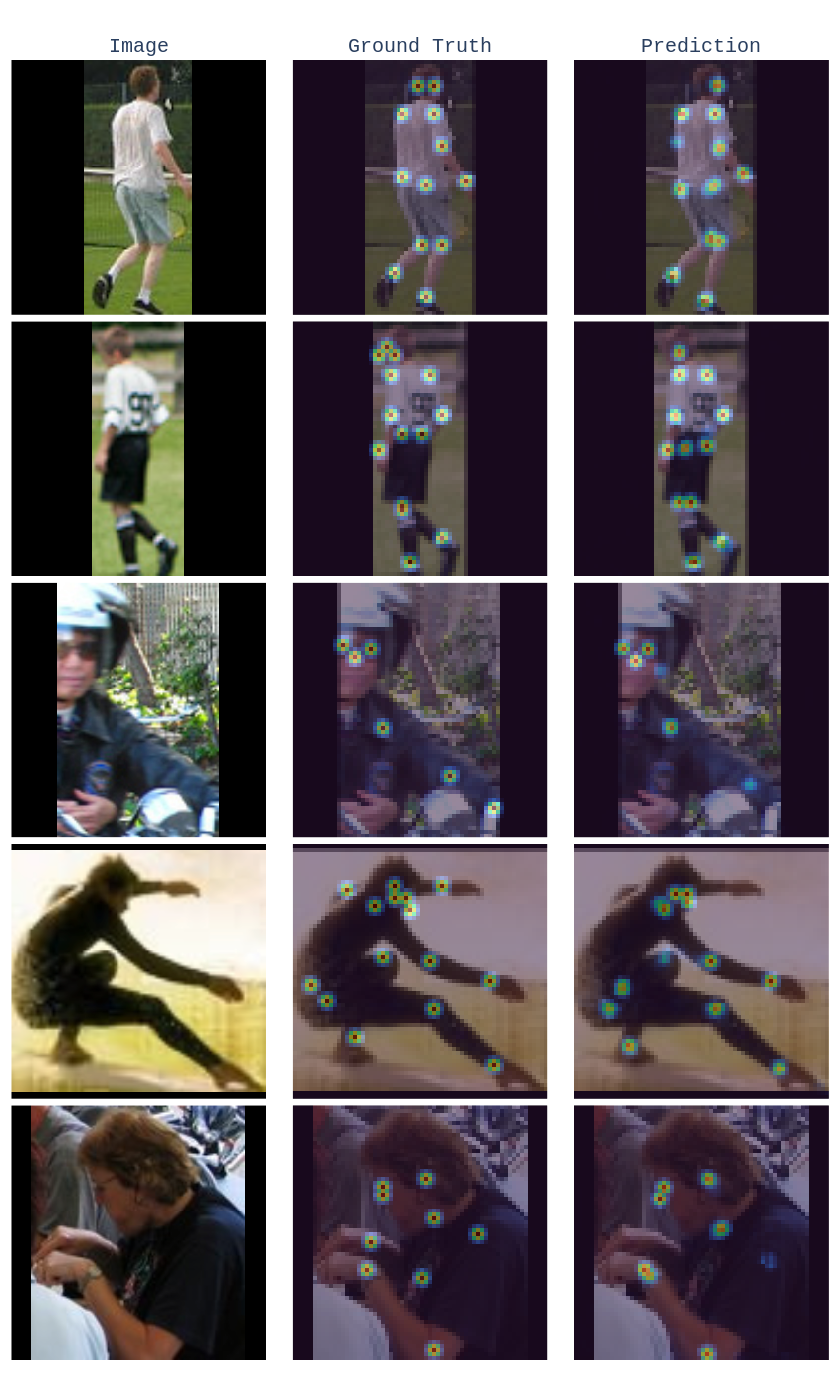

In [14]:
fig = GridDisplay([BatchDisplay(image=sample_val_batch["image"][:5], title="Image"),
                   BatchDisplay(image=sample_val_batch["image_down"][:5], masks=sample_val_masks_gt[:5], title="Ground Truth", color_map="turbo"),
                   BatchDisplay(image=sample_val_batch["image_down"][:5], masks=sample_val_masks_pred[:5], title="Prediction", color_map="turbo")
                  ])
fig.show()